In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
bsz = 30
epochs = 1000
seqlen = 16

z_size = 2
n_hidden = 128
n_gaussians = 3

torch.Size([30, 100, 2])

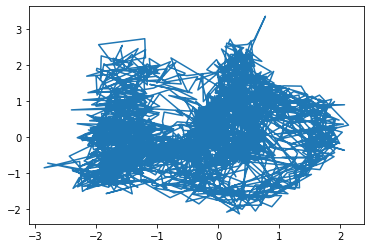

In [130]:
#import funs
from scipy import signal
z = np.loadtxt('lfads_k09_01131727.csv', delimiter=',')
#z[:,0] = signal.savgol_filter(z[:,0], 21, 5)
#z[:,1] = signal.savgol_filter(z[:,1],21, 5)
plt.figure()
plt.plot(z[:,0],z[:,1])
z = torch.from_numpy(z)
z = z.view(bsz, -1, z.size(1)).to(device)
z.shape

In [5]:
# Truncated backpropagation
def detach(states):
    return [state.detach() for state in states] 

In [6]:
class MDNRNN(nn.Module):
    def __init__(self, z_size, n_hidden=256, n_gaussians=3, n_layers=1):
        super(MDNRNN, self).__init__()

        self.z_size = z_size
        self.n_hidden = n_hidden
        self.n_gaussians = n_gaussians
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(z_size, n_hidden, n_layers, batch_first=True)
        self.fc1 = nn.Linear(n_hidden, n_gaussians*z_size)
        self.fc2 = nn.Linear(n_hidden, n_gaussians*z_size)
        self.fc3 = nn.Linear(n_hidden, n_gaussians*z_size)
        
    def get_mixture_coef(self, y):
        rollout_length = y.size(1)
        pi, mu, sigma = self.fc1(y), self.fc2(y), self.fc3(y)
        
        pi = pi.view(-1, rollout_length, self.n_gaussians, self.z_size)
        mu = mu.view(-1, rollout_length, self.n_gaussians, self.z_size)
        sigma = sigma.view(-1, rollout_length, self.n_gaussians, self.z_size)
        
        pi = F.softmax(pi, 2)
        sigma = torch.exp(sigma)
        return pi, mu, sigma
        
        
    def forward(self, x, h):
        # Forward propagate LSTM
        y, (h, c) = self.lstm(x, h)
        pi, mu, sigma = self.get_mixture_coef(y)
        return (pi, mu, sigma), (h, c)
    
    def init_hidden(self, bsz):
        return (torch.zeros(self.n_layers, bsz, self.n_hidden).to(device),
                torch.zeros(self.n_layers, bsz, self.n_hidden).to(device))

In [7]:
model = MDNRNN(z_size, n_hidden).to(device)
# model.load_state_dict(torch.load('rnn.torch', map_location='cpu'))

In [8]:
# inputs = z[:bsz, :seqlen, :]
# (pi, mu, sigma), (h, c) = model(inputs, model.init_hidden(bsz))
# inputs.shape, pi.shape

In [9]:
def mdn_loss_fn(y, pi, mu, sigma):
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    loss = torch.exp(m.log_prob(y))
    loss = torch.sum(loss * pi, dim=2)
    loss = -torch.log(loss)
    return loss.mean()

In [10]:
def criterion(y, pi, mu, sigma):
    y = y.unsqueeze(2)
    return mdn_loss_fn(y, pi, mu, sigma)

In [11]:
optimizer = torch.optim.Adam(model.parameters())

In [12]:
# Train the model
for epoch in range(epochs):
    # Set initial hidden and cell states
    hidden = model.init_hidden(bsz)
    
    for i in range(0, z.size(1) - seqlen, seqlen):
        # Get mini-batch inputs and targets
        inputs = z[:, i:i+seqlen, :].float() 
        targets = z[:, (i+1):(i+1)+seqlen, :].float() 
        
        # Forward pass
        hidden = detach(hidden)
        (pi, mu, sigma), hidden = model(inputs, hidden)
        loss = criterion(targets, pi, mu, sigma)
        
        # Backward and optimize
        model.zero_grad()
        loss.backward()
        # clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        
    if epoch % 100 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'
               .format(epoch, epochs, loss.item()))

Epoch [0/1000], Loss: 1.3614
Epoch [100/1000], Loss: -0.0084
Epoch [200/1000], Loss: -0.1375
Epoch [300/1000], Loss: -0.3469
Epoch [400/1000], Loss: -0.4831
Epoch [500/1000], Loss: -0.6624
Epoch [600/1000], Loss: -0.8040
Epoch [700/1000], Loss: -0.8667
Epoch [800/1000], Loss: -1.0362
Epoch [900/1000], Loss: -1.2881


In [13]:
# np.linalg.norm(z[0, 0, :].cpu().data - z1[0, :, :].cpu().data, axis=1)
# np.linalg.norm(inputs.cpu().data - targets.cpu().data)

### RNN prediction
There are 5 modes of gaussians. Below is next true sample and 5 modes of predictions

tensor([[[0.7740, 0.3582]]])
[0.3523927  0.01677656] [0.6635201  0.23175687] [0.6738181  0.39051485]
tensor([[[[0.2881, 0.3474],
          [0.3873, 0.4014],
          [0.2770, 0.4819]]]], grad_fn=<ExpBackward0>)


<IPython.core.display.Javascript object>


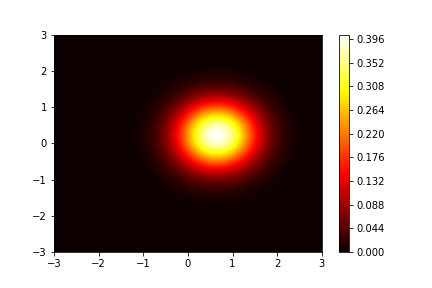

In [165]:
zero = np.random.randint(z.size(0))
one = np.random.randint(z.size(1))
x = z[zero:zero+1, one:one+1, :].float() 

hidden = model.init_hidden(1)
print(x)
(pi, mu, sigma), _ = model(x, hidden)

def f(x, y, mu, S):
  x_norm = (np.array([x, y]) - mu[:, None, None]).transpose(1, 2, 0)
  return np.exp(- x_norm[:, :, None, :] @ np.linalg.inv(S)[None, None, :, :] @ x_norm[:, :, :, None] / 2.0) / (2*np.pi*np.sqrt(np.linalg.det(S)))

x = np.linspace(-3,3,500)
y = np.linspace(-3,3,500)
X, Y = np.meshgrid(x,y)

mu1 = mu[0][0][0].detach().numpy().copy()
mu2 = mu[0][0][1].detach().numpy().copy()
mu3 = mu[0][0][2].detach().numpy().copy()
print(mu3,mu2,mu1)
print(sigma)
S1 = np.array([[sigma[0][0][0][0].detach().numpy().copy(),0],[0,sigma[0][0][0][1].detach().numpy().copy()]])
S2 = np.array([[sigma[0][0][1][0].detach().numpy().copy(),0],[0,sigma[0][0][1][1].detach().numpy().copy()]])
S3 = np.array([[sigma[0][0][2][0].detach().numpy().copy(),0],[0,sigma[0][0][2][1].detach().numpy().copy()]])

Z = f(X,Y, mu1, S1)[:, :, 0, 0]*pi[0][0][0][0].detach().numpy().copy() + f(X,Y, mu2, S2)[:, :, 0, 0]*pi[0][0][1][0].detach().numpy().copy() \
+ f(X,Y, mu3, S3)[:, :, 0, 0]*pi[0][0][2][0].detach().numpy().copy()


fig2 = plt.figure()
ax2 = plt.subplot(111)
cs = ax2.contourf(X,Y,Z,100, cmap="hot")
plt.colorbar(cs)

plt.show()

<IPython.core.display.Javascript object>


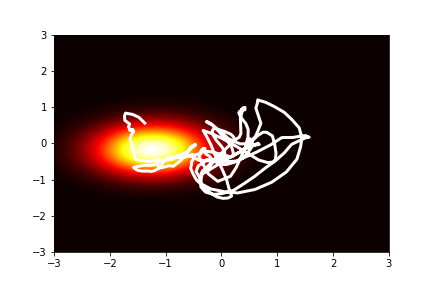

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


In [177]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def update(i, x, y):
    if i != 0:
        plt.cla() 
    plt.plot(x[0:i], y[0:i], "w", lw=3) 
    hidden = model.init_hidden(1)
    zero = np.random.randint(z.size(0))
    one = np.random.randint(z.size(1))
    x0 = z[zero:zero+1, one:one+1, :].float() 
    x0[0][0][0] = x[i]
    x0[0][0][1] = y[i]
    (pi, mu, sigma), _ = model(x0, hidden)
    mu1 = mu[0][0][0].detach().numpy().copy()
    mu2 = mu[0][0][1].detach().numpy().copy()
    mu3 = mu[0][0][2].detach().numpy().copy()
    S1 = np.array([[sigma[0][0][0][0].detach().numpy().copy(),0],[0,sigma[0][0][0][1].detach().numpy().copy()]])
    S2 = np.array([[sigma[0][0][1][0].detach().numpy().copy(),0],[0,sigma[0][0][1][1].detach().numpy().copy()]])
    S3 = np.array([[sigma[0][0][2][0].detach().numpy().copy(),0],[0,sigma[0][0][2][1].detach().numpy().copy()]])

    Z = f(X,Y, mu1, S1)[:, :, 0, 0]*pi[0][0][0][0].detach().numpy().copy() + f(X,Y, mu2, S2)[:, :, 0, 0]*pi[0][0][1][0].detach().numpy().copy() \
    + f(X,Y, mu3, S3)[:, :, 0, 0]*pi[0][0][2][0].detach().numpy().copy()
    plt.contourf(X,Y,Z,100, cmap="hot")
    plt.xlim(-3,3)
    plt.ylim(-3,3)

def draw():
    fig = plt.figure() 
    #x = np.arange(0, 10, 1)
    z0 = np.loadtxt('lfads_k09_01131727.csv', delimiter=',')
    z0[:,0] = signal.savgol_filter(z0[:,0], 21, 5)
    z0[:,1] = signal.savgol_filter(z0[:,1],21, 5)
    x = z0[:300,0]
    y = z0[:300,1]
    ani = animation.FuncAnimation(fig, update, fargs = (x, y), interval = 1, frames = 300)
    ani.save("test.gif", writer = 'imagemagick')
draw()